# Bayesian Inference 2: Project Report

### Title: ""

### Name: Antti Härkönen


## Abstract

> A graphical Bayesian regression model with

## Introduction

This project deals with the spatial segregation of ethnic groups in the city of Vyborg in 1880. At the time the city was
a part of Autonomous Grand Duchy of Finland, which was a part of the Russian Empire. The city had unusually diverse, but
mostly Lutheran, population. The members of the sizable Russian minority were mainly members Russian Orthodox church and
had a distinct identity, but little is known about how well they were integrated with the other population groups. One
important indicator of integration is spatial segregation. This can be studied using archival materials, but measuring
different kinds segregation is difficult. Obviously, there is some level of economic segregation, where the richer merchants
lived in the better parts of the town. Also, when the population of any minority group is affected by the same spatial
conditions as everyone, which means that the general population density has to be accounted for when studying the spatial
distributions of a minority group. My aim is to determine whether a hidden segregation variable can be inferred using
the existing data. In a regression context, this would mean studying whether or not the coefficient for the effect of
the hidden variable is around zero.

A Generalized linear model with Poisson distribution is used to model the size of Orthodox population in a location.
One of the variables used to predict number of Orthodox people is a hypothetical unobserved variable S, which stands for
segregation which is not caused by income differences. Other unobserved variables are the regression coefficients for the
Poisson regression.

Python libraries used in this project are the following:
* pymc3 for specifying Bayesian models
* geopandas for reading, manipulating and plotting geospatial data
* pandas and numpy for managing data
* matplotlib for scatter plots and histograms
* arviz for visualising results of Bayesian computations

The aim of this project is to learn about the graphical models that could be used for studying challenging statistical
inference problems.
To my knowledge, there are no comparable studies of modeling high resolution spatial segregation that could be used as
guidelines in this project.

## Methods

### Dataset description and processing

A spatial dataset containing demographic and tax data from the city Vyborg in 1880 is used as data. The data is created
by combining data from following sources:
* Religious affiliation of inhabitants of each household is recorded in the poll tax register of 1880
* Paid income tax is recorded in the Income tax register of 1880
* Location of each city plot is determined using a variety of digitized, georeferenced and vectorized historical maps

These sources are combined using plot numbers found in each source and joining them with Python tools such as pandas and
geopandas. Since the data is 140 years old, modern regulations about storing personal information do not apply.

There are three columns that are relevant for current model in the dataset:
* total: Total number of inhabitants in location k
* orthodox: Total number of Eastern Orthodox inhabitants in location k
* income_per_person: Income per capita in location k

The number of orthodox people is proxy for ethnically Russian population, since well over 90 percent of Orthodox civilian
population of Vyborg were Russians.

The population variables are discrete count data, while per capita income is a continuous variable.

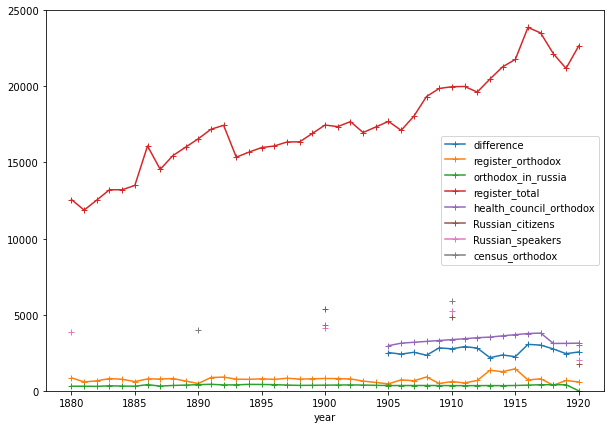

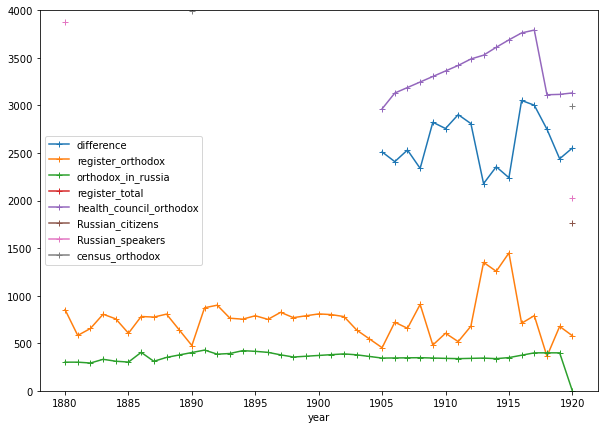

In [3]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = Path('./data')
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['orthodox'] = poll_tax['orthodox'].interpolate(method='linear')
poll_tax['in_russia_orthodox'] = poll_tax['in_russia_orthodox'].interpolate(method='linear', limit=2).fillna(0)
poll_tax['total'] = (poll_tax.total_women + poll_tax.total_men).interpolate(method='linear')
remove = poll_tax.in_russia_orthodox.copy()
remove.loc['1906':] = 0
poll_tax['orthodox'] = poll_tax.orthodox - remove
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
health_council = health_council.reindex(range(1880, 1921), fill_value=np.nan).interpolate(method='slinear')
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
difference = health_council - poll_tax.orthodox
data = pd.DataFrame([
    difference,
    poll_tax.orthodox,
    poll_tax.in_russia_orthodox,
    poll_tax.total,
    health_council,
    foreigners,
    language,
    religion,
]).T
data.columns = [
    'difference',
    'register_orthodox',
    'orthodox_in_russia',
    'register_total',
    'health_council_orthodox',
    'Russian_citizens',
    'Russian_speakers',
    'census_orthodox',
]
# data.interpolate(method='linear', inplace=True)
data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 25_000))
data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 4_000))
plt.show()

### Model description


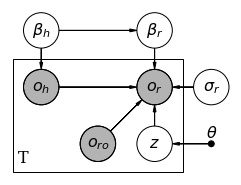

In [4]:
import daft
from matplotlib import rc

rc("font", family="serif", size=16)
scale = 1.25
pgm = daft.PGM()

pgm.add_node('health_orthodox', r'$o_{h}$', 1, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('register_orthodox', r'$o_{r}$', 3, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('russia_orthodox', r'$o_{ro}$', 2, 1, fixed=False, scale=scale, observed=True)
pgm.add_node('beta_orthodox_health', r'$\beta_h$', 1, 3, fixed=False, scale=scale, observed=False)
pgm.add_node('beta_orthodox_register', r'$\beta_r$', 3, 3, fixed=False, scale=scale, observed=False)
pgm.add_node('theta', r'$\theta$', 4, 1, fixed=True, scale=scale, observed=False)
pgm.add_node('z', r'$z$', 3, 1, fixed=False, scale=scale, observed=False)
pgm.add_node('sigma_register', r'$\sigma_r$', 4, 2, fixed=False, scale=scale, observed=False)

pgm.add_edge('health_orthodox', 'register_orthodox', directed=True)
pgm.add_edge('russia_orthodox', 'register_orthodox', directed=True)
pgm.add_edge('z', 'register_orthodox', directed=True)
pgm.add_edge('beta_orthodox_health', 'health_orthodox', directed=True)
pgm.add_edge('beta_orthodox_health', 'beta_orthodox_register', directed=True)
pgm.add_edge('beta_orthodox_register', 'register_orthodox', directed=True)
pgm.add_edge('sigma_register', 'register_orthodox', directed=True)
pgm.add_edge('theta', 'z', directed=True)

pgm.add_plate([0.5, 0.5, 3, 2], 'T')

pgm.render()

Model:

$ o_r = N(\mu_{o_h}, \sigma_{o_h}^2) $

$ \mu_{o_h} = \beta_0 + \beta_1 t - o_{ro} z $

$ \sigma_{o_h} \sim Exp(10) $

$ \theta = \begin{bmatrix} 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 \end{bmatrix}' $

$ z \sim Bernoulli(\theta) $

$ \beta_h \sim N\begin{pmatrix}\begin{bmatrix} 0.2 \\ 0.005 \end{bmatrix},
 \begin{bmatrix} 0.01 && 0 \\ 0 && 0.001 \end{bmatrix}\end{pmatrix} $

$ \beta_r \sim N\begin{pmatrix}\begin{bmatrix} 0.21 \times 0.3 \\ 0.004 \end{bmatrix},
 \begin{bmatrix} 0.005 && 0 \\ 0 && 0.001 \end{bmatrix}\end{pmatrix} $

Joint probability of the model:

For the most variables the priors chosen are wide. This is because there is little prior knowledge about them given lack
of earlier research.

### Inference Method

Hamiltonian Monte Carlo simulation is used to infer latent variables. The model is built using Python statistical inference library
[PyMC3](https://docs.pymc.io/) which implements No U-Turn Sampler (NUTS), which is a gradient-based Monte Carlo method. Since $\bf z$
is a binary variable, it has to be estimated using the Binary Gibbs-Metropolis sampling step.


## Experiment & Results


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 24900
Interrupted at 24,899 [12%]: Average Loss = 1.8385e+05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_health_1, beta_health_0]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8850097608737244, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_health_1, beta_health_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

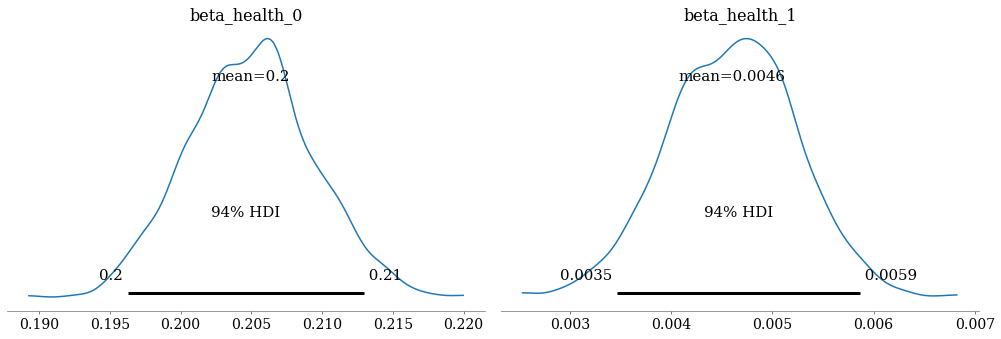

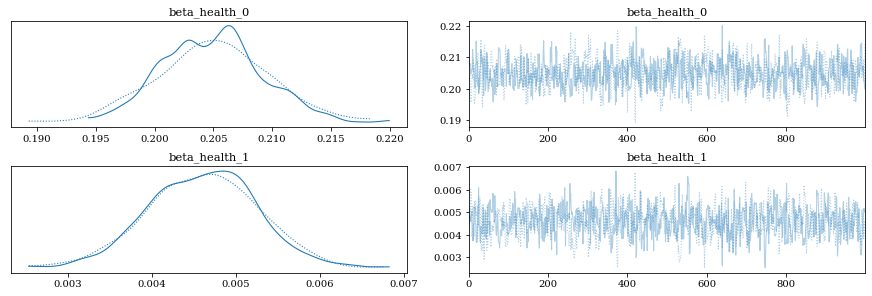

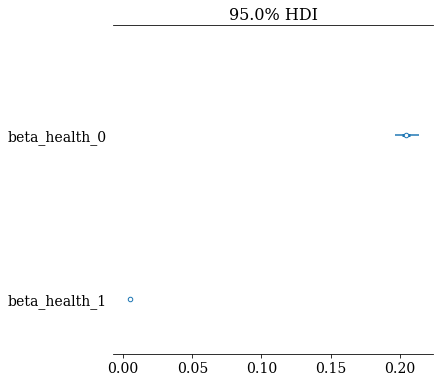

In [5]:
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

data_pm = data.iloc[26:-3,]
standard = 15_000
data_pm = data_pm / standard
start = 1906
data_pm['t'] = data_pm.index - start

with pm.Model() as model_health_council_orthodox:
    n, _ = data_pm.shape
    t = np.asarray(data_pm.t)
    beta_health_0 = pm.Normal(
        "beta_health_0",
        mu=0.2,
        sigma=0.01,
    )
    beta_health_1 = pm.Normal(
        "beta_health_1",
        mu=0.005,
        sigma=0.001,
    )
    # mu_health = tt.add(beta_health_0, tt.mul(beta_health_1, data_pm.t))
    mu_health = beta_health_0 + t * beta_health_1
    # sigma_total = pm.Exponential('sigma_total', 100)
    health_council = pm.Normal(
        'health_council',
        mu=mu_health,
        sigma=0.01,
        observed=np.asarray(data_pm.health_council_orthodox),
    )

    trace_health = pm.sample(1000, tune=2000, init="advi+adapt_diag")
    prior_health = pm.sample_prior_predictive()
    posterior_health = pm.sample()
    posterior_pred_health = pm.sample_posterior_predictive(posterior_health)

az.plot_posterior(posterior_health)
az.plot_trace(posterior_health)
az.plot_forest(posterior_health, combined=True, hdi_prob=0.95)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma_orthodox, beta_orthodox_1, beta_orthodox_0]
>BinaryGibbsMetropolis: [z]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 17 seconds.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma_orthodox, beta_orthodox_1, beta_orthodox_0]
>BinaryGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

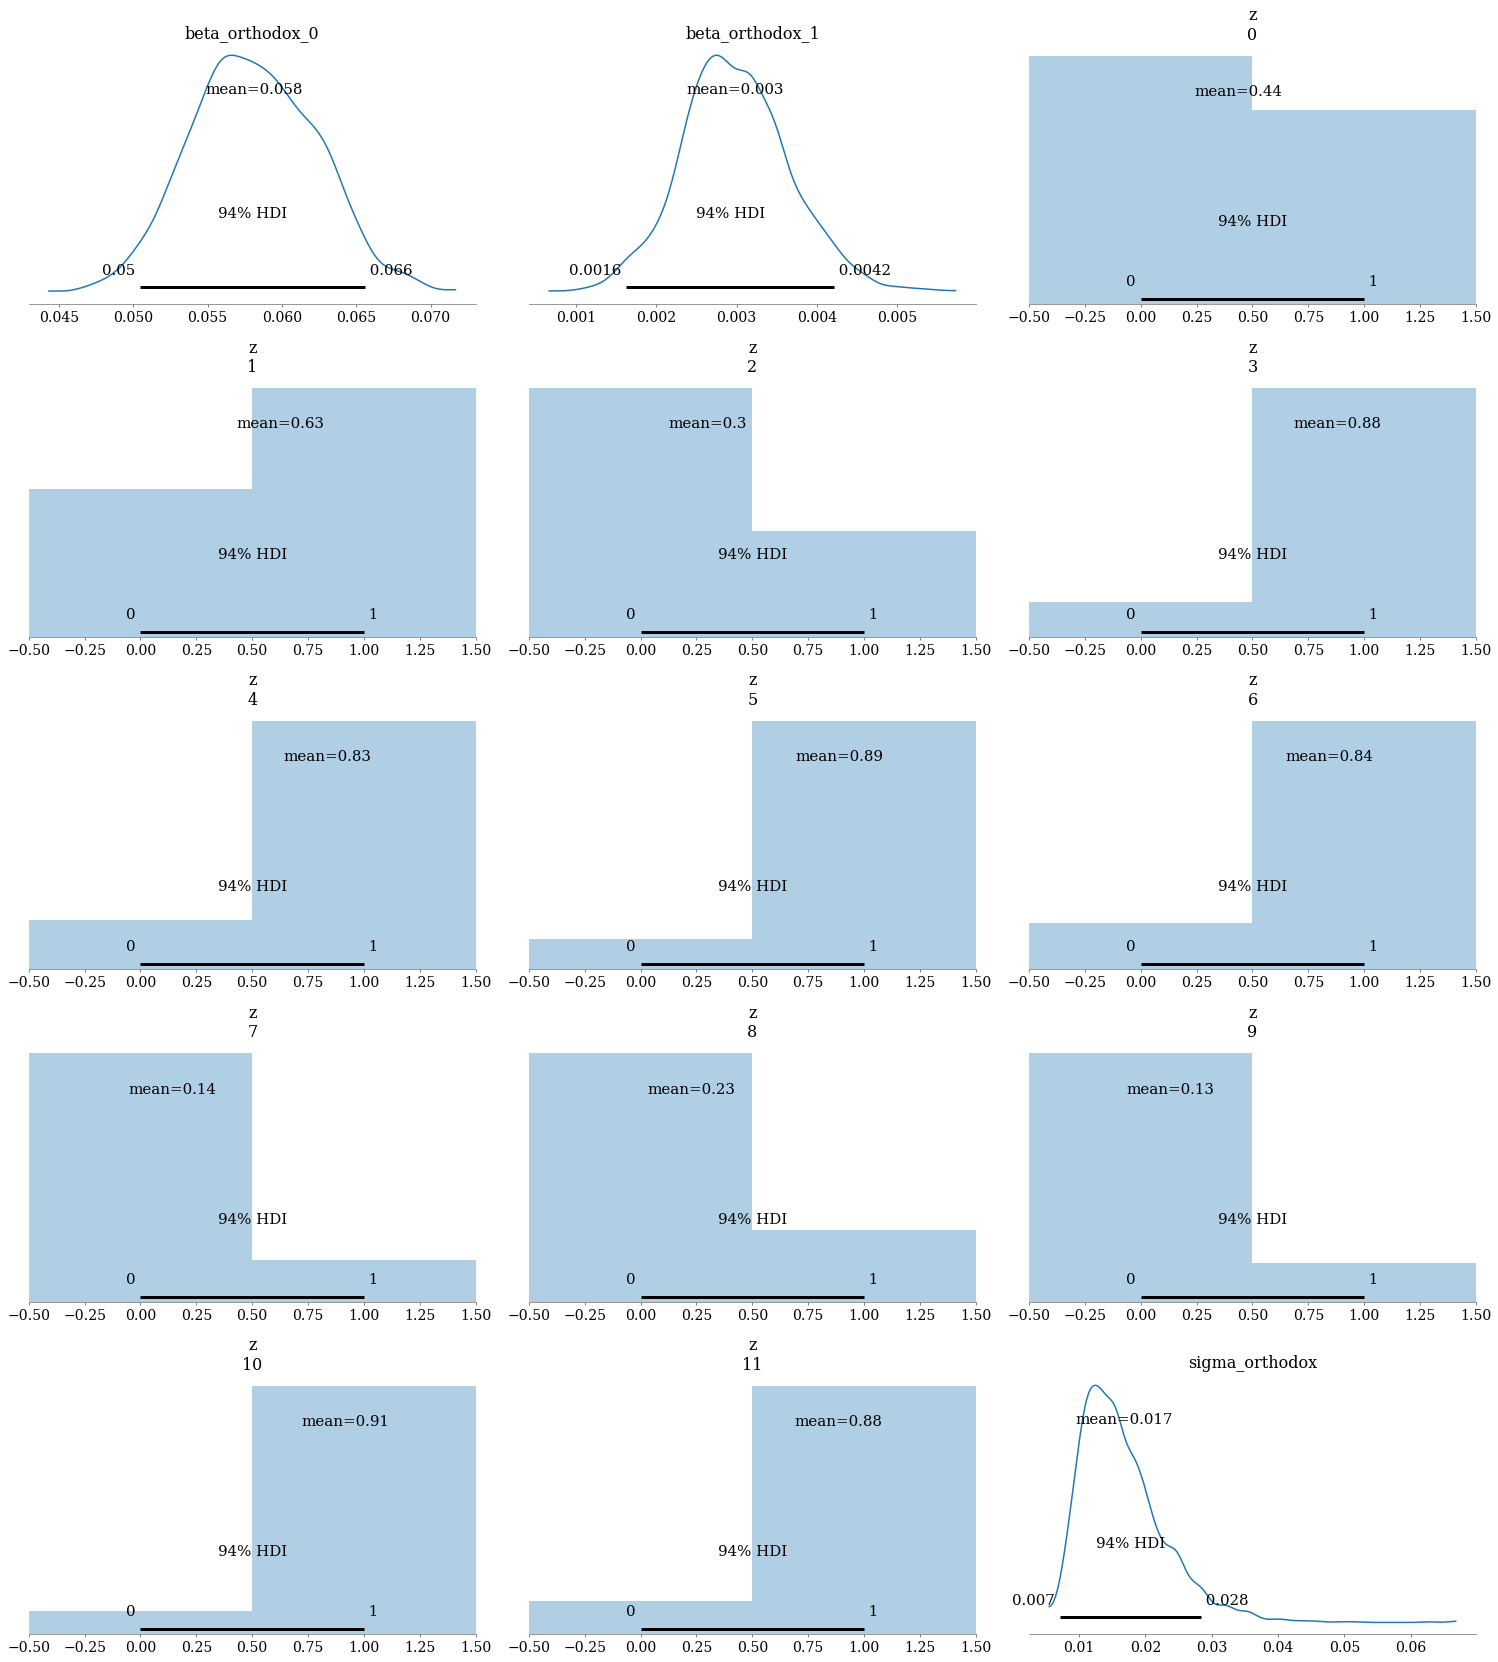

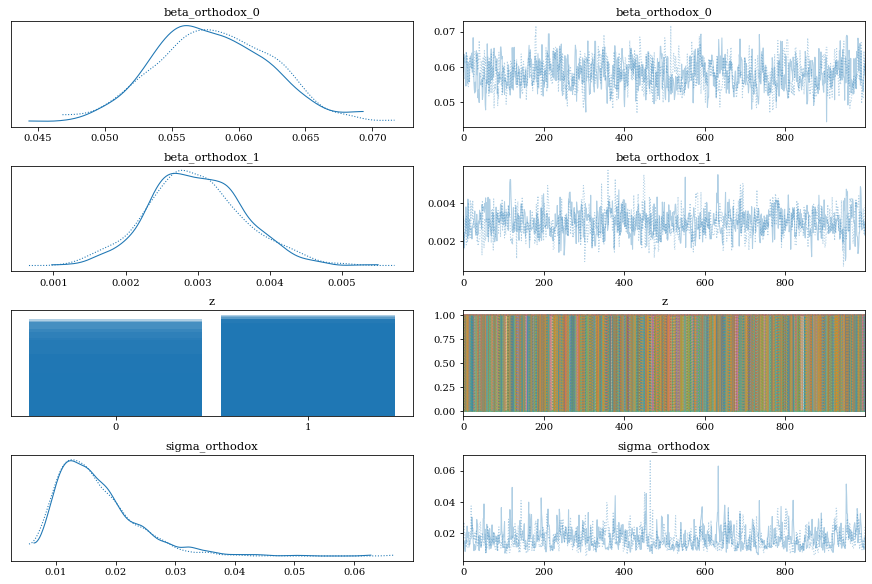

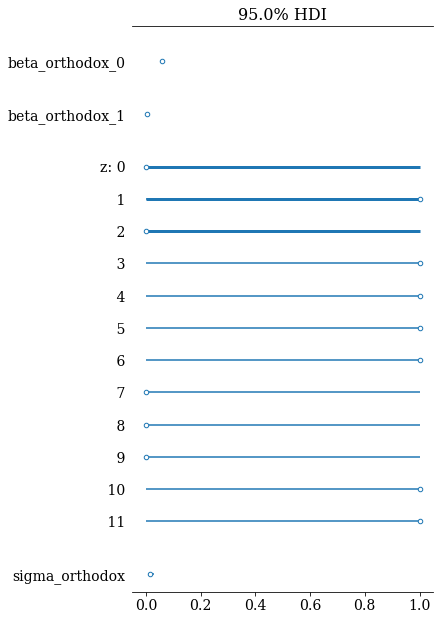

In [6]:
mu_beta_orthodox_0 = 0.21 * 0.3
mu_beta_orthodox_1 = 0.004

with pm.Model() as model_orthodox:
    beta_orthodox_0 = pm.Normal(
        "beta_orthodox_0",
        mu=mu_beta_orthodox_0,
        sigma=0.005,
    )
    beta_orthodox_1 = pm.Normal(
        "beta_orthodox_1",
        mu=mu_beta_orthodox_1,
        sigma=0.001,
    )
    theta = 0.5
    z = pm.Bernoulli('z', p=theta, shape=n)
    sigma_total = pm.Exponential('sigma_orthodox', 10)
    missing = np.asarray(data_pm.orthodox_in_russia) * z
    mu_total = beta_orthodox_0 + beta_orthodox_1 * t - missing
    total = pm.Normal(
        'register',
        mu=mu_total,
        sigma=sigma_total,
        observed=data_pm.register_orthodox,
    )

    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag")
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=True, hdi_prob=0.95)

## Discussion and conclusion

The results do not indicate that there is a significant amount of segregation that would affect the distribution
of Russian Orthodox population apart from wealth and general population density.

However, more research is needed to determine whether there are differences between different districts of the city,
as these results could result from the ecological fallacy, i.e. the analysis results may depend on the spatial scale of
regression. One approach to studying the districts would be a hierarchical regression model with pooling of data.
In any case, the problem of spatial segregation involves interactions between many known and unknown
variables, and these kinds of problems must be studied using Bayesian multilevel models.
